In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob, os, json

In [3]:
# Loading json file
path_to_json = 'dataset/labels/'
labels = []
full_description = []

for file_name in [file for file in os.listdir(path_to_json) if file.endswith('.json')]:
    with open(path_to_json + file_name) as json_file:
        data = json.load(json_file)
        pts = []
        for plate in data['shapes']:
            pts.append(plate['points'])
        full_description.append(data)
        labels.append(pts)

In [4]:
labels[3][0]

[[207.4074074074074, 194.17989417989418],
 [281.6137566137566, 193.38624338624336],
 [281.48148148148147, 226.58730158730157],
 [207.67195767195767, 226.98412698412696]]

In [5]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [6]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)


Loading model successfully...


In [7]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Found 196 images...


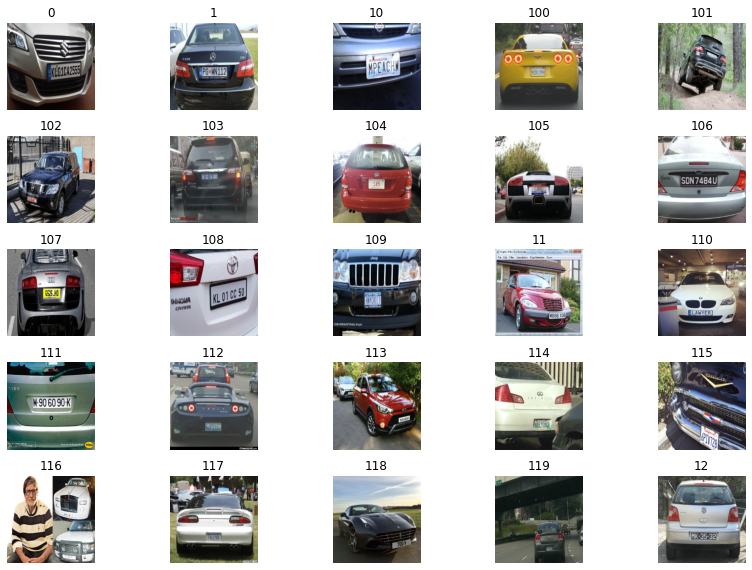

In [194]:
# Create a list of image paths 
image_paths = glob.glob("dataset/images/*.png")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 5
rows = 5
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()


Detect 2 plate(s) in Cars0
Coordinate of plate(s) in image: 
 [array([[301.02856953, 417.98741605, 418.00574537, 301.04689885],
       [125.22687977, 123.84731724, 167.5846394 , 168.96420193],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[315.74689656, 341.40424044, 349.21022289, 323.552879  ],
       [ 66.51200118,  74.6238934 ,  90.17104251,  82.05915029],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


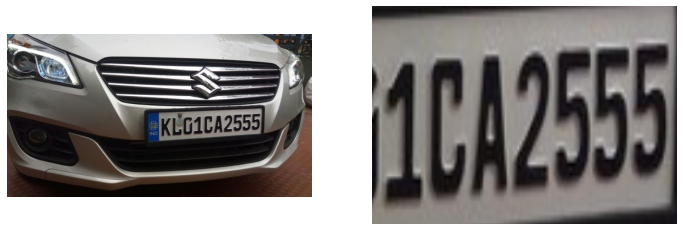

In [10]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    # print("Height {}, Width {}".format(vehicle.shape[0], vehicle.shape[1]) )
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
image_paths = glob.glob("dataset/images/*.png")
test_image = image_paths[0]
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

#plt.savefig("part1_result.jpg",dpi=300)

In [9]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(image_path, Dmax=608, Dmin=300):
    vehicle = preprocess_image(image_path)
    # print("Height {}, Width {}".format(vehicle.shape[0], vehicle.shape[1]) )
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

In [10]:
def get_XY_coor(X_list, Y_list):
    coor = []
    for i in range(4):
        x = X_list[i]
        y = Y_list[i]
        coor.append([x,y])
    return coor

In [11]:
from shapely.geometry import box, Polygon
def IOU(pol1_xy, pol2_xy):
    # Define each polygon
    polygon1_shape = Polygon(pol1_xy)
    polygon2_shape = Polygon(pol2_xy)

    # intersection
    polygon_intersection = polygon1_shape.intersection(polygon2_shape).area
    
    # union = shape1 + shape2 - union
    polygon_union = polygon1_shape.area + polygon2_shape.area - polygon_intersection
    
    # IOU = intersection / union
    return polygon_intersection / polygon_union

In [47]:
def calculate_AP(preList, recList):
    
    pre = preList.copy()
    pre.append(1)
    rec = recList.copy()
    rec.append(0)
    precisions = np.array(pre)
    recalls = np.array(rec)
    ap = np.sum((recalls[:-1] - recalls[1:]) * precisions[:-1])
        
    return ap

In [149]:
image_paths = glob.glob("dataset/images/*.png")

In [128]:
len(labels[16])

3

**reduce calculation**

In [172]:
import timeit

iou = []
check = []
for i in range(196):
    test_image = image_paths[i]
    LpImg,cor = get_plate(test_image)
    if i%10 == 0:
        print(i)
    for p in range(len(LpImg)):
        X = cor[p][0]
        Y = cor[p][1]
        coor_predict = get_XY_coor(X, Y)
        maxIOU = 0
        for l in range(len(labels[i])):
            coor_label = labels[i][l]
            maxIOU = max(maxIOU, IOU(coor_label, coor_predict))
        iou.append(maxIOU)
        check.append([i, maxIOU])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [173]:
preList = []
recList = []
for alpha in range(50,100,5):
    TP = 0
    FP = 0
    FN = 0
    start = timeit.default_timer()
    for i in iou:
        if i > float(alpha/100):
            TP += 1
        elif i == 0:
            FN += 1
        else:
            FP += 1
    
    precision = (TP)/(TP+FP)
    preList.append(precision)
    
    recall = (TP)/(TP+FN)
    recList.append(recall)
    
    stop = timeit.default_timer()
    print('Time: ', stop - start, '. Alpha: ', alpha)
    print('Precision: ', precision, '. Recall: ', recall)

Time:  0.00023629999850527383 . Alpha:  50
Precision:  0.9560975609756097 . Recall:  0.8634361233480177
Time:  0.0003023999997822102 . Alpha:  55
Precision:  0.9463414634146341 . Recall:  0.8622222222222222
Time:  0.0007692999988648808 . Alpha:  60
Precision:  0.9073170731707317 . Recall:  0.8571428571428571
Time:  0.0005239000001893146 . Alpha:  65
Precision:  0.8829268292682927 . Recall:  0.8537735849056604
Time:  0.0005368000001908513 . Alpha:  70
Precision:  0.8585365853658536 . Recall:  0.8502415458937198
Time:  0.0005856000007042894 . Alpha:  75
Precision:  0.7414634146341463 . Recall:  0.8306010928961749
Time:  0.0005696999996871455 . Alpha:  80
Precision:  0.6097560975609756 . Recall:  0.8012820512820513
Time:  0.00028529999872262124 . Alpha:  85
Precision:  0.4195121951219512 . Recall:  0.7350427350427351
Time:  0.0007003999999142252 . Alpha:  90
Precision:  0.13658536585365855 . Recall:  0.4745762711864407
Time:  0.0005066000012448058 . Alpha:  95
Precision:  0.01463414634146

In [174]:
calculate_AP(preList, recList)

0.25446245296625497

In [179]:
lower = []
for c in check:
    if c[1] < 0.5:
        lower.append(c)

In [188]:
lower

[[0, 0],
 [8, 0],
 [8, 0],
 [11, 0.24482518505830625],
 [13, 0],
 [13, 0],
 [29, 0],
 [31, 0],
 [32, 0.3748929417029512],
 [37, 0],
 [38, 0],
 [45, 0.0070322629130517966],
 [48, 0],
 [60, 0],
 [62, 0],
 [62, 0],
 [65, 0],
 [70, 0.47891039879186453],
 [71, 0],
 [73, 0.0383235669663526],
 [87, 0.4181151169610545],
 [94, 0.4933568913606824],
 [96, 0],
 [100, 0],
 [111, 0],
 [112, 0],
 [113, 0],
 [115, 0],
 [119, 0],
 [130, 0.4026701898329088],
 [131, 0],
 [157, 0],
 [159, 0.22613004503774323],
 [159, 0],
 [167, 0],
 [167, 0],
 [171, 0],
 [174, 0],
 [179, 0],
 [185, 0]]

**Draw bounding box**

In [60]:
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the bottom-left, bottom-right, top-right, top-left
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IOU:  0.47891039879186453


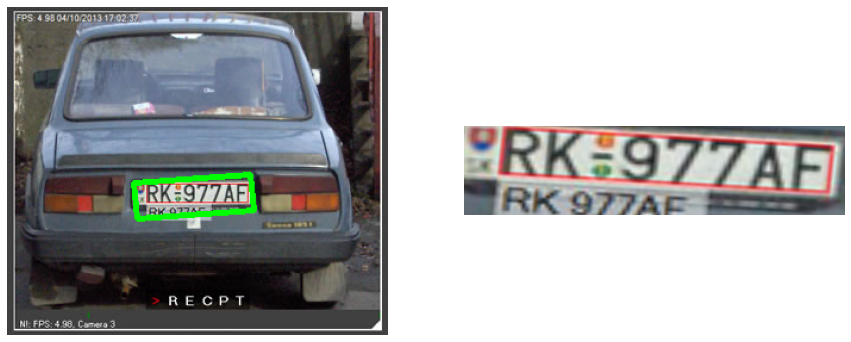

In [202]:
index = 70

image_paths = glob.glob("dataset/images/*.png")
test_image = image_paths[index]
LpImg,cor = get_plate(test_image, Dmin=300)

X = cor[0][0]
Y = cor[0][1]
coor_predict = get_XY_coor(X, Y)
coor_label = labels[index][0]
print('IOU: ', IOU(coor_label, coor_predict))

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])
plt.savefig("result.jpg",dpi=80)

In [203]:
len(LpImg)

1

In [183]:
len(labels[index])

1

In [189]:
lower

[[0, 0],
 [8, 0],
 [8, 0],
 [11, 0.24482518505830625],
 [13, 0],
 [13, 0],
 [29, 0],
 [31, 0],
 [32, 0.3748929417029512],
 [37, 0],
 [38, 0],
 [45, 0.0070322629130517966],
 [48, 0],
 [60, 0],
 [62, 0],
 [62, 0],
 [65, 0],
 [70, 0.47891039879186453],
 [71, 0],
 [73, 0.0383235669663526],
 [87, 0.4181151169610545],
 [94, 0.4933568913606824],
 [96, 0],
 [100, 0],
 [111, 0],
 [112, 0],
 [113, 0],
 [115, 0],
 [119, 0],
 [130, 0.4026701898329088],
 [131, 0],
 [157, 0],
 [159, 0.22613004503774323],
 [159, 0],
 [167, 0],
 [167, 0],
 [171, 0],
 [174, 0],
 [179, 0],
 [185, 0]]